IMPORTING LIBRARIES AND LOADING DIABETES DATA

In [1]:
import pickle
import xgboost
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)

df = pd.read_csv("/content/pima-data.csv")

df.head()

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3790,True
1,1,85,66,29,0,26.6,0.351,31,1.1426,False
2,8,183,64,0,0,23.3,0.672,32,0.0000,True
3,1,89,66,23,94,28.1,0.167,21,0.9062,False
4,0,137,40,35,168,43.1,2.288,33,1.3790,True


FEATURE ENGINEERING

In [ ]:
# dataset shape : number of records x number of features
print(df.shape)

# checking for null values:
print(df.isnull().values.any())

(768, 10)
False


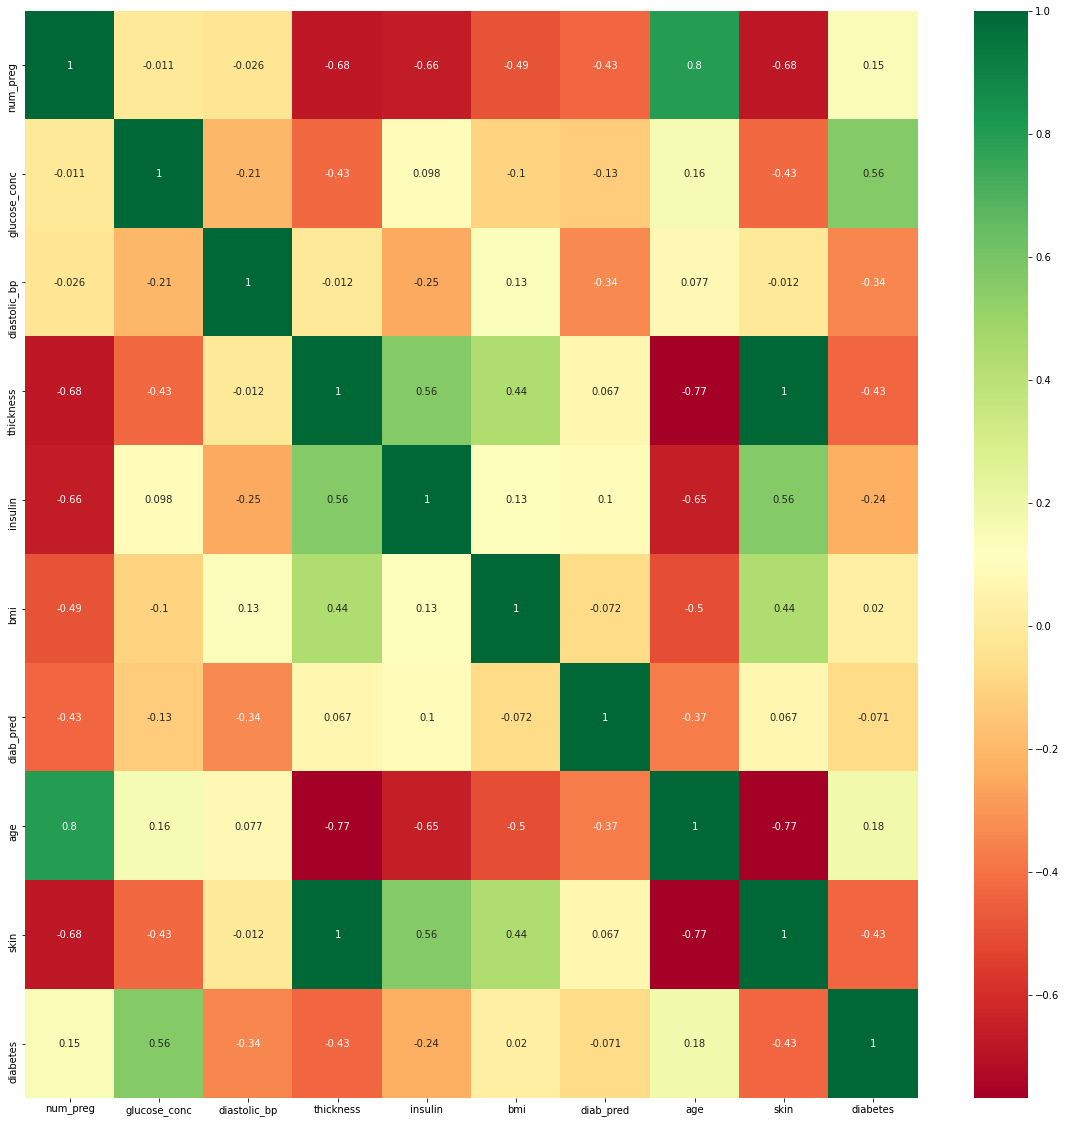

In [ ]:
# correlation
corr_mat = df.corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(20, 20))
g = sns.heatmap(corr_mat[top_corr_features].corr(), annot=True, cmap="RdYlGn")

In [3]:
# converting output label i.e. df[diabetes] from boolean to int.
df['diabetes'] = df['diabetes'].map({True : 1, False: 0})

In [4]:
df.head()

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3790,1
1,1,85,66,29,0,26.6,0.351,31,1.1426,0
2,8,183,64,0,0,23.3,0.672,32,0.0000,1
3,1,89,66,23,94,28.1,0.167,21,0.9062,0
4,0,137,40,35,168,43.1,2.288,33,1.3790,1


In [5]:
diabetes_true_count = len(df.loc[df['diabetes'] == 1])
diabetes_false_count = len(df.loc[df['diabetes'] == 0])

In [6]:
print("Data having 1 as output: {}".format(diabetes_true_count))
print("Data having 0 as output: {}".format(diabetes_false_count))

Data having 1 as output: 268
Data having 0 as output: 500


FEATURE SELECTION BASED ON CORRELATION

In [7]:
selected_features = ['num_preg', 'glucose_conc', 'diastolic_bp', 'insulin', 'bmi', 'diab_pred', 'age', 'skin']
output_class = ['diabetes']

In [8]:
# converting from df to np array
X = df[selected_features].values
y = df[output_class].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# checking values which are 0:
print("total number of rows : {0}".format(len(df)))
print("number of rows missing glucose_conc: {0}".format(len(df.loc[df['glucose_conc'] == 0])))
print("number of rows missing glucose_conc: {0}".format(len(df.loc[df['glucose_conc'] == 0])))
print("number of rows missing diastolic_bp: {0}".format(len(df.loc[df['diastolic_bp'] == 0])))
print("number of rows missing insulin: {0}".format(len(df.loc[df['insulin'] == 0])))
print("number of rows missing bmi: {0}".format(len(df.loc[df['bmi'] == 0])))
print("number of rows missing diab_pred: {0}".format(len(df.loc[df['diab_pred'] == 0])))
print("number of rows missing age: {0}".format(len(df.loc[df['age'] == 0])))
print("number of rows missing skin: {0}".format(len(df.loc[df['skin'] == 0])))

total number of rows : 768
number of rows missing glucose_conc: 5
number of rows missing glucose_conc: 5
number of rows missing diastolic_bp: 35
number of rows missing insulin: 374
number of rows missing bmi: 11
number of rows missing diab_pred: 0
number of rows missing age: 0
number of rows missing skin: 227


In [11]:
# imputing these missing/zero values

missing_values_imputer = SimpleImputer(missing_values=0, strategy='mean')

X_train = missing_values_imputer.fit_transform(X_train)
X_test = missing_values_imputer.fit_transform(X_test)

In [12]:
X_train.shape, X_test.shape

((614, 8), (154, 8))

APPLYING MACHINE LEARNING ALGORITHM

In [13]:
# using random forest classifier
rfc = RandomForestClassifier(random_state=10) # ravel : from (n,m) => (n,)
rfc.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [14]:
# random forest classifier accuracy:
y_preds = rfc.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 75.32%


In [15]:
# using xgboost

# hyperparameter optimization

params = {
    "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth"        : [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [1, 3, 5, 7],
    "gamma"            : [0.0, 0.1, 0.2 , 0.3, 0.4],
    "colsample_bytree" : [0.3, 0.4, 0.5, 0.7]
}

clf = xgboost.XGBClassifier()

random_search = RandomizedSearchCV(
    clf, 
    param_distributions=params, 
    n_iter=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=5, 
    verbose=3
)

random_search.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.2s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                           verbosity=1),
                   iid='deprecated', n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0

In [16]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4,
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [17]:
classifier = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4,
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

classifier.fit(X_train, y_train.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4,
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [18]:
score = cross_val_score(classifier, X_train, y_train.ravel(), cv=10)
print(score.mean())

0.7540983606557378


In [19]:
# xgboost classifier accuracy:
y_preds = classifier.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 77.27%


In [20]:
# saving trained model
filename = '/content/diabetes.sav'
pickle.dump(classifier, open(filename, 'wb'))

# loading trained model
# model = pickle.load(open(filename, 'rb'))
# result = model.score(X_test, y_test)
# print(result)